In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
!pip install scikit-learn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from nltk import flatten

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

import seaborn as sns

import shap

import time
import joblib

import sklearn.metrics

import statistics

from tqdm import tqdm

In [ ]:
class HotelDataset(Dataset):
  def __init__(self, split='train'):
    """
    1. Load the data, e.g. df= pd.Feather load ()

    Data preprocessing:
    - Make sure fast indexing, so, maybe use guest_id as index
    - New time index, running from 1 (first time) ... last_time
    - Data needs to be all numerical, use encoders to encode data if needed before hand
    - Normalize data
    """
    self.scaled_df = pd.read_csv('output/10_selected_guest_data/df_original_data_standardscaler', index_col = [0,1])
    self.scaled_df = self.scaled_df.drop(["amount_times_visited", "weekday_arrival_date", "weekday_creation_date"], axis = 1)
    self.scaled_df.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.scaled_df.index])
    self.scaled_df = self.scaled_df.iloc[1:, :]
    missing_rows = self.scaled_df.isnull().any(axis = 1)
    self.scaled_df = self.scaled_df[~missing_rows]
    guests = self.scaled_df.index.get_level_values(0)
    self.guest_idx = np.unique([guests[0]] + list(guests[1:].astype(str)))
    self.split_indexes = self.train_test_split(split)
    self.y = pd.read_csv('output/10_selected_guest_data/y_original_data', index_col = [0,1])
    self.y.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.y.index])
    self.y = self.y[~missing_rows.values]
    return

  def train_test_split(self, split):
    np.random.seed(42)
    max_guests = len(self.guest_idx)
    n = int(max_guests * 0.8)

    indexes = np.random.permutation(max_guests)

    if split == "train":
      return indexes[:n]
    elif split == "validation":
      return indexes[n:]

  def __len__(self):
    """
    np.unique(guests)
    """
    return len(self.split_indexes)

  def __getitem__(self, idx):
    """
    idx --> guest_id
    self.df[idx]
    """

    idx = self.split_indexes[idx]
    chosen_guest = self.scaled_df.loc[self.guest_idx[idx]]
    y_guest = self.y.loc[self.guest_idx[idx]]
    y_array = y_guest.to_numpy().squeeze(1)
    columns_guest = chosen_guest.columns
    guest_array = chosen_guest.to_numpy()  # [sequence length, columns]

    cut_off = np.random.randint(1, guest_array.shape[0]) if guest_array.shape[0] > 1 else 1
    return guest_array[:cut_off, :], y_array[cut_off -1]


In [ ]:
data_train = HotelDataset(split='train')
data_test = HotelDataset(split='validation')

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


**Getting the data ready for the test set**
TODO: Change the variable 24 to another variable with the amount of variables to add with new dataset.

In [ ]:
list_length = []
for i,data in enumerate(data_test):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  if seq_length[0] < 79:
    list_length.append(seq_length)

In [ ]:
for value in max(list_length):
  max_value = value

X_test = []
y_test = []
for i,data in tqdm(enumerate(data_test), total=len(data_test)):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  list_seqs = []
  if seq_length[0] < 79:
    added_data = 78 - seq_length[0]
    added_data_list = [-10] * (added_data * 21)
    seqs = [j for sub in booking_seqs for j in sub]
    for list_seq in seqs:
      list_seqs.extend(list_seq)
    list_seqs.extend(added_data_list)
    y_test.append(labels[0])
    X_test.append(list_seqs)

100%|██████████| 3268/3268 [00:06<00:00, 509.74it/s]


**Getting the data ready for the train set**

In [ ]:
list_length = []
for i,data in enumerate(data_train):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  if seq_length[0] < 79:
    list_length.append(seq_length)

In [ ]:
for value in max(list_length):
  max_value = value
X_train = []
y_train = []
for i,data in tqdm(enumerate(data_train), total=len(data_train)):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  list_seqs = []
  if seq_length[0] < 79:
    added_data = 78 - seq_length[0]
    added_data_list = [-10] * (added_data * 21)
    seqs = [j for sub in booking_seqs for j in sub]
    for list_seq in seqs:
      list_seqs.extend(list_seq)
    list_seqs.extend(added_data_list)
    y_train.append(labels[0])
    X_train.append(list_seqs)

100%|██████████| 13069/13069 [00:17<00:00, 745.57it/s]


In [ ]:
y_train = np.array(y_train)
not_1000 = y_train != -1000
X_train = np.array(X_train)

For training ten times

In [ ]:
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
for i in range(10):
  regr = RandomForestRegressor(max_depth = 3, n_estimators = 30)
  start_time = time.time()
  regr.fit(X_train[not_1000], (y_train[not_1000]))
  t = time.time() - start_time
  t = round(t)
  joblib.dump(regr, "Trained_models/rfr_model_finalbusiness_{0}_{1}.pkl".format(i, t))
  predicted_y = regr.predict(X_test)
  y_test = np.array(y_test)
  y_test_df = pd.DataFrame(y_test, columns = ["labels"])
  predicted_y_df = pd.DataFrame(predicted_y, columns = ["next_event"])
  df_old = pd.concat([y_test_df, predicted_y_df], axis = 1)
  df_old.columns = ["labels", "next_event"]
  df_sorted = df_old.copy()
  rmse = np.sqrt(mean_squared_error(df_sorted["labels"], df_sorted["next_event"]))
  mae = mean_absolute_error(df_sorted["labels"], df_sorted["next_event"])
  df_sorted["labels_label"] = 0
  df_sorted["next_event_label"] = 0
  for i in range(len(df_sorted)):
    if df_sorted["labels"][i] < 117:
      df_sorted["labels_label"][i] = 1
    elif 117 < df_sorted["labels"][i] < 295:
      df_sorted["labels_label"][i] = 2
    elif 295 < df_sorted["labels"][i] < 411:
      df_sorted["labels_label"][i] = 3
    else:
      df_sorted["labels_label"][i] = 4
    if df_sorted["next_event"][i] < 117:
      df_sorted["next_event_label"][i] = 1
    elif 117 < df_sorted["next_event"][i] < 295:
      df_sorted["next_event_label"][i] = 2
    elif 295 < df_sorted["next_event"][i] < 411:
      df_sorted["next_event_label"][i] = 3
    else:
      df_sorted["next_event_label"][i] = 4
  rmse_list.append(rmse)
  mae_list.append(mae)
  precision_list.append(sklearn.metrics.precision_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro"))
  recall_list.append(sklearn.metrics.recall_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro"))
  f1_list.append(sklearn.metrics.f1_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro"))
  time_list.append(t)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
print(np.mean(rmse_list))
print(np.mean(mae_list))
print(np.mean(precision_list))
print(np.mean(recall_list))
print(np.mean(f1_list))
print(np.mean(time_list))

In [ ]:
stringbusiness = ["Trained_models/rfr_model_finalbusiness_9_0.pkl"]

In [ ]:
stringoriginal = ["Trained_models/rfr_model_finaloriginal_0_95.pkl", "Trained_models/rfr_model_finaloriginal_1_96.pkl", "Trained_models/rfr_model_finaloriginal_2_65.pkl", "Trained_models/rfr_model_finaloriginal_3_46.pkl", "Trained_models/rfr_model_finaloriginal_4_47.pkl", "Trained_models/rfr_model_finaloriginal_5_46.pkl", "Trained_models/rfr_model_finaloriginal_6_45.pkl", "Trained_models/rfr_model_finaloriginal_7_44.pkl", "Trained_models/rfr_model_finaloriginal_8_48.pkl", "Trained_models/rfr_model_finaloriginal_9_47.pkl"]

In [ ]:
stringleisure = ["Trained_models/rfr_model_finalleisure_0_52.pkl", "Trained_models/rfr_model_finalleisure_1_53.pkl", "Trained_models/rfr_model_finalleisure_2_46.pkl", "Trained_models/rfr_model_finalleisure_3_35.pkl", "Trained_models/rfr_model_finalleisure_4_35.pkl", "Trained_models/rfr_model_finalleisure_5_33.pkl", "Trained_models/rfr_model_finalleisure_6_32.pkl", "Trained_models/rfr_model_finalleisure_7_31.pkl", "Trained_models/rfr_model_finalleisure_8_32.pkl", "Trained_models/rfr_model_finalleisure_9_33.pkl"]

In [ ]:
stringbalancedII = ["Trained_models/rfr_model_finalbalancedII_0_13.pkl", "Trained_models/rfr_model_finalbalancedII_1_13.pkl", "Trained_models/rfr_model_finalbalancedII_2_13.pkl", "Trained_models/rfr_model_finalbalancedII_3_13.pkl", "Trained_models/rfr_model_finalbalancedII_4_14.pkl", "Trained_models/rfr_model_finalbalancedII_5_13.pkl", "Trained_models/rfr_model_finalbalancedII_6_13.pkl", "Trained_models/rfr_model_finalbalancedII_7_13.pkl", "Trained_models/rfr_model_finalbalancedII_8_13.pkl", "Trained_models/rfr_model_finalbalancedII_9_13.pkl"]

In [ ]:
stringbalancedI = ["Trained_models/rfr_model_finalbalancedI_0_15.pkl", "Trained_models/rfr_model_finalbalancedI_1_16.pkl", "Trained_models/rfr_model_finalbalancedI_2_15.pkl", "Trained_models/rfr_model_finalbalancedI_3_17.pkl", "Trained_models/rfr_model_finalbalancedI_4_15.pkl", "Trained_models/rfr_model_finalbalancedI_5_16.pkl", "Trained_models/rfr_model_finalbalancedI_6_23.pkl", "Trained_models/rfr_model_finalbalancedI_7_16.pkl", "Trained_models/rfr_model_finalbalancedI_8_15.pkl", "Trained_models/rfr_model_finalbalancedI_9_16.pkl"]

In [ ]:
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
# for string in stringbusiness:
model = joblib.load(original[-1])
predicted_y = model.predict(X_test)
y_test = np.array(y_test)
y_test_df = pd.DataFrame(y_test, columns = ["labels"])
predicted_y_df = pd.DataFrame(predicted_y, columns = ["next_event"])
df_old = pd.concat([y_test_df, predicted_y_df], axis = 1)
df_old.columns = ["labels", "next_event"]
df_sorted = df_old.copy()
rmse = np.sqrt(mean_squared_error(df_sorted["labels"], df_sorted["next_event"]))
mae = mean_absolute_error(df_sorted["labels"], df_sorted["next_event"])
print(f"rmse: {rmse}")
print(f"mae: {mae}")
df_sorted["labels_label"] = 0
df_sorted["next_event_label"] = 0
for i in range(len(df_sorted)):
  if df_sorted["labels"][i] < 117:
    df_sorted["labels_label"][i] = 1
  elif 117 < df_sorted["labels"][i] < 295:
    df_sorted["labels_label"][i] = 2
  elif 295 < df_sorted["labels"][i] < 411:
    df_sorted["labels_label"][i] = 3
  else:
    df_sorted["labels_label"][i] = 4
  if df_sorted["next_event"][i] < 117:
    df_sorted["next_event_label"][i] = 1
  elif 117 < df_sorted["next_event"][i] < 295:
    df_sorted["next_event_label"][i] = 2
  elif 295 < df_sorted["next_event"][i] < 411:
    df_sorted["next_event_label"][i] = 3
  else:
    df_sorted["next_event_label"][i] = 4
precision_score = sklearn.metrics.precision_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
recall_score = sklearn.metrics.recall_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
f1_score = sklearn.metrics.f1_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
rmse_list.append(rmse)
mae_list.append(mae)
precision_list.append(precision_score)
recall_list.append(recall_score)
f1_list.append(f1_score)

rmse: 261.1730145780636
mae: 212.4415259069934



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [ ]:
print(np.mean(rmse_list))
print(np.mean(mae_list))
print(np.mean(precision_list))
print(np.mean(recall_list))
print(np.mean(f1_list))

0.503208015917478
0.35348083327917534
0.3372652582180109


**Evaluation metrics**

In [ ]:
y_test_a = np.array(df_sorted["labels"])
y_pred_a = np.array(df_sorted["next_event"])
not_1000 = y_test_a != -1000

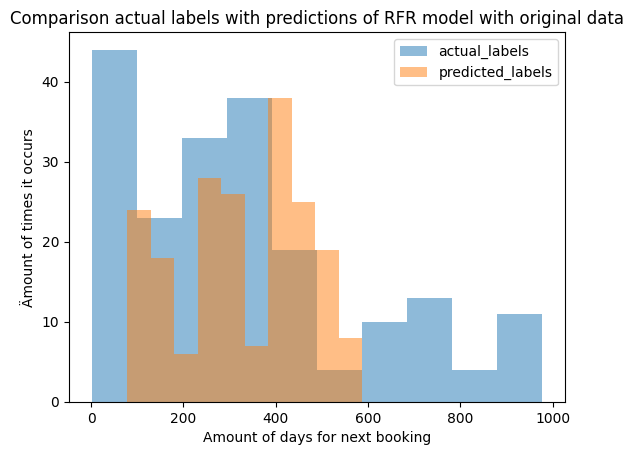

In [ ]:
plt.hist(y_test_a[not_1000], alpha = 0.5, label ="actual_labels")
plt.hist(y_pred_a[not_1000], alpha = 0.5, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of RFR model with original data")
plt.xlabel("Amount of days for next booking")
plt.ylabel("Ämount of times it occurs")
plt.legend(prop ={'size': 10})



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



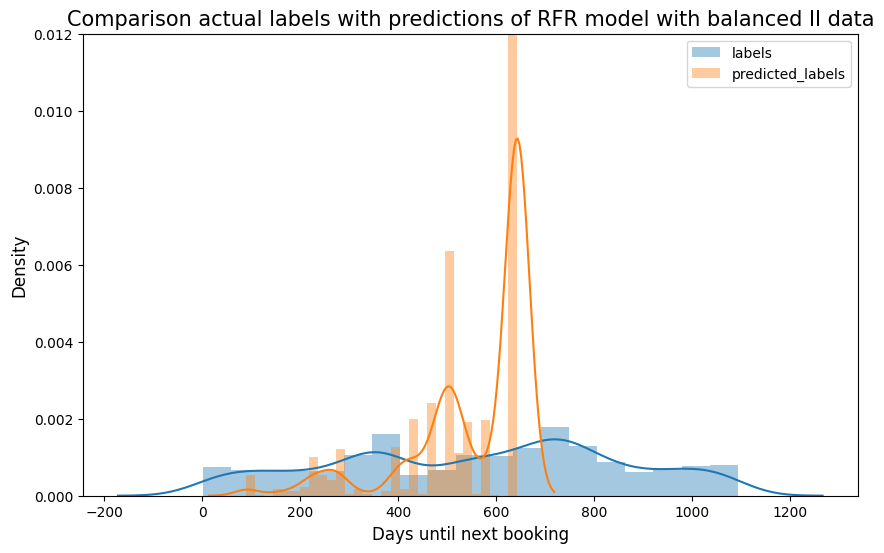

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test_a[not_1000],hist = True, label ="labels")
sns.distplot(y_pred_a[not_1000],hist = True, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of RFR model with balanced II data", size = 15)
plt.xlabel("Days until next booking", size = 12)
plt.ylabel("Density", size = 12)
# plt.xlim(-100,)
plt.ylim(0, 0.012)
# plt.ylim(0, 0.0025)
plt.legend()



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Text(0, 0.5, 'Density')

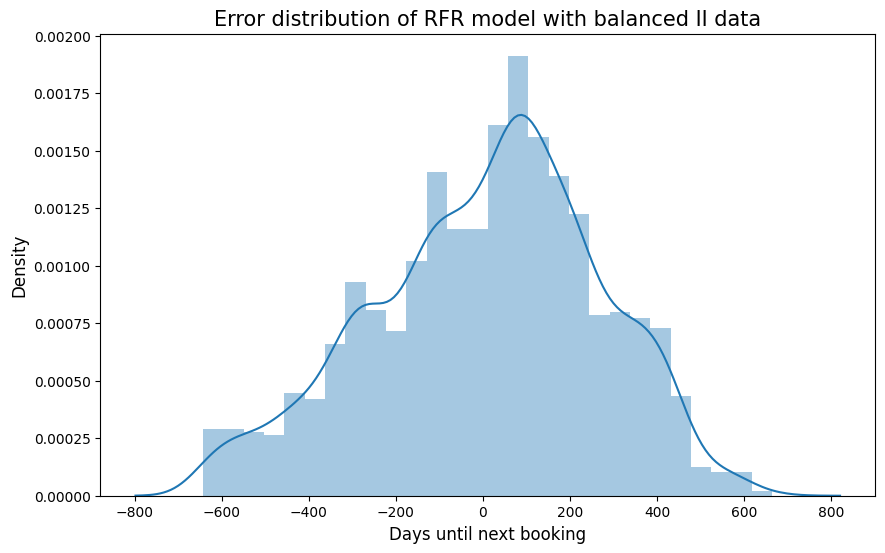

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(y_test_a[not_1000] - y_pred_a[not_1000],hist = True)
plt.title("Error distribution of RFR model with balanced II data", size = 15)
plt.xlabel("Days until next booking", size = 12)
plt.ylabel("Density", size = 12)

**Confusion matrix**

In [ ]:
cm = confusion_matrix(df_sorted["labels_label"], df_sorted["next_event_label"])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn, index = [1, 2, 3, 4], columns = [1,2,3,4])

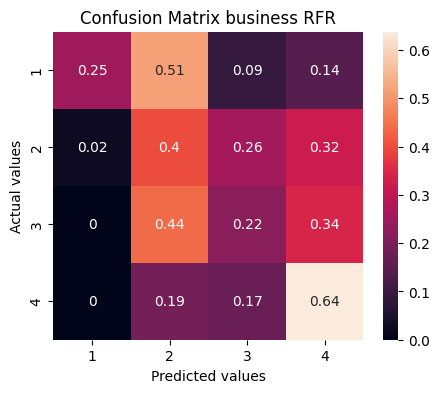

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True)
plt.title("Confusion Matrix business RFR")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()